<h1>Análise Preditiva de aluguéis em Nova York</h1>

<h4>Análise e Comparação de Performance de Modelos de Machine Learning </h4>


Alunos:
- Guilherme Rosada
- Jamesson Leandro Paivas Santos
___

In [26]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import perf_counter
from math import sqrt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR

import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

# Preparando os dados

Para este projeto, trabalharemos com duas bases de dados, disponibilizadas pelo [AirBnB](http://insideairbnb.com/new-york-city/) , mas que também podem ser encontradas no [Kaggle](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data?datasetId=268833&sortBy=voteCount). Para juntá-las, faremos um merge com a coluna `id`

In [27]:
# https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data?datasetId=268833&sortBy=voteCount
df1 = pd.read_csv('AB_NYC_2019.csv', index_col='id')
df2 = pd.read_csv('listings.csv', index_col='id')

# juntando as duas bases em uma única:
colunas_relevantes = ["property_type", "accommodates",  "review_scores_value", 
                      "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", 
                      "review_scores_communication", "review_scores_checkin", "review_scores_rating", 
                      "maximum_nights", "host_is_superhost", "host_response_time", "host_response_rate",  
                      'bathrooms', 'bedrooms', 'beds']
nyc = pd.merge(df1, df2[colunas_relevantes], on='id', how='left')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Ajustando dados faltantes

Antes de analisarmos nossos dados, precisamos checar sua completude e, se necessário, realizar os devidos ajustes.

# Análise Exploratória

In [39]:
nyc.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,host_is_superhost,host_response_time,host_response_rate,bathrooms,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,...,10.0,10.0,95.0,1125.0,f,within a few hours,90%,1.0,0.0,1.0
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,...,NaN,NaN,NaN,7.0,f,within a day,100%,1.0,1.0,1.0
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,...,9.0,10.0,90.0,730.0,f,within an hour,90%,1.0,1.0,4.0
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,...,10.0,10.0,93.0,120.0,f,NaN,NaN,1.0,NaN,1.0


In [6]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month         

In [7]:
nyc.isnull().sum()

name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
property_type                      3371
accommodates                       3371
review_scores_value               12629
review_scores_cleanliness         12594
review_scores_location            12631
review_scores_accuracy            12611
review_scores_communication       12605
review_scores_checkin             12627
review_scores_rating              12573
maximum_nights                     3371


Vamos dropar a coluna `last_review`, pois não é tão relevante para o modelo.

Como `review_scores` não tem um desvio padrão tão alto, vamos substituir os vazios pela média.

Para o restante, preencheremos com o valor da média.

In [9]:
nyc.drop(columns=['last_review'], inplace=True)

reviews = ['review_scores_value', 'review_scores_cleanliness', 
           'review_scores_location', 'review_scores_accuracy', 
           'review_scores_communication', 'review_scores_checkin', 
           'review_scores_rating']

for i in reviews:
    nyc[i].fillna(nyc[i].mean(), inplace=True)

nyc['accommodates'].fillna(nyc['accommodates'].mean(), inplace=True)
nyc['maximum_nights'].fillna(nyc['maximum_nights'].mean(), inplace=True)
nyc['reviews_per_month'] = nyc['number_of_reviews'] / 12

a = ['bathrooms', 'beds', 'bedrooms']
for i in a:
    nyc[i].fillna(nyc[i].mean(), inplace=True)

In [10]:
nyc.isnull().sum()

name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
property_type                      0
accommodates                       0
review_scores_value                0
review_scores_cleanliness          0
review_scores_location             0
review_scores_accuracy             0
review_scores_communication        0
review_scores_checkin              0
review_scores_rating               0
maximum_nights                     0
host_is_superhost                  0
host_response_time                 0
host_response_rate                 0
b

Para as colunas categóricas, preencheremos com o valor mais frequente

In [8]:
colunas_categoricas = ['host_response_time', 'host_response_rate', 'property_type', 'host_is_superhost']

for i in colunas_categoricas:
    nyc[i].fillna(nyc[i].value_counts().idxmax(), inplace=True)

Vamos analisar a nossa variável de interesse `price`

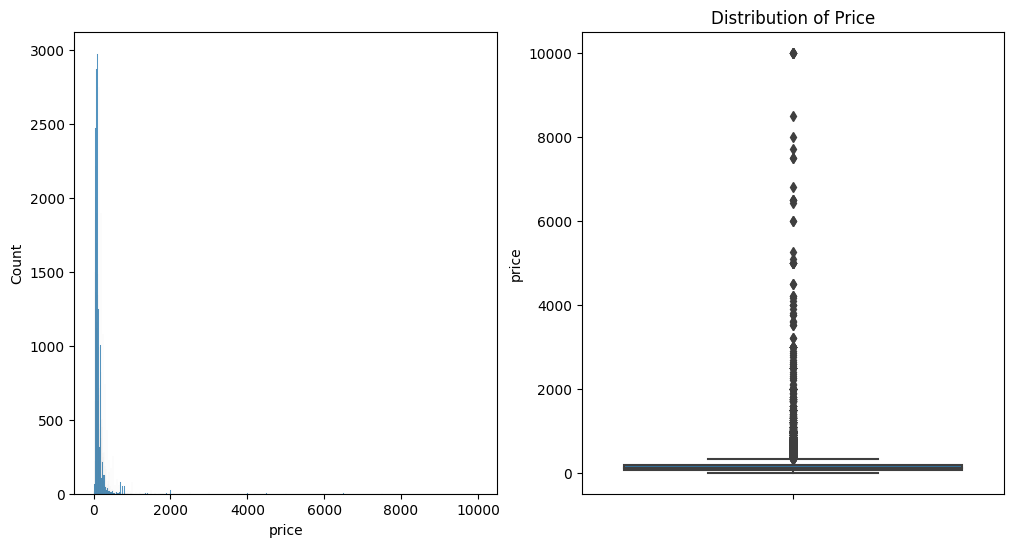

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(nyc['price'])

plt.subplot(1,2,2)
sns.boxplot(y=nyc['price'])
plt.title("Distribution of Price")
plt.show()

Percebe-se que a faixa de preço distoa bastante. Vamos excluir alguns outliers.

In [11]:
mean = nyc['price'].mean()
std = nyc['price'].std()

print(f"média: {mean}, desvio padrão: {std}")

média: 152.7206871868289, desvio padrão: 240.15416974718758


In [12]:
# Vamos remover valores acima de 3 desvios padrão

limite_max = mean + 3 * std
nyc = nyc[nyc['price'] <= limite_max]

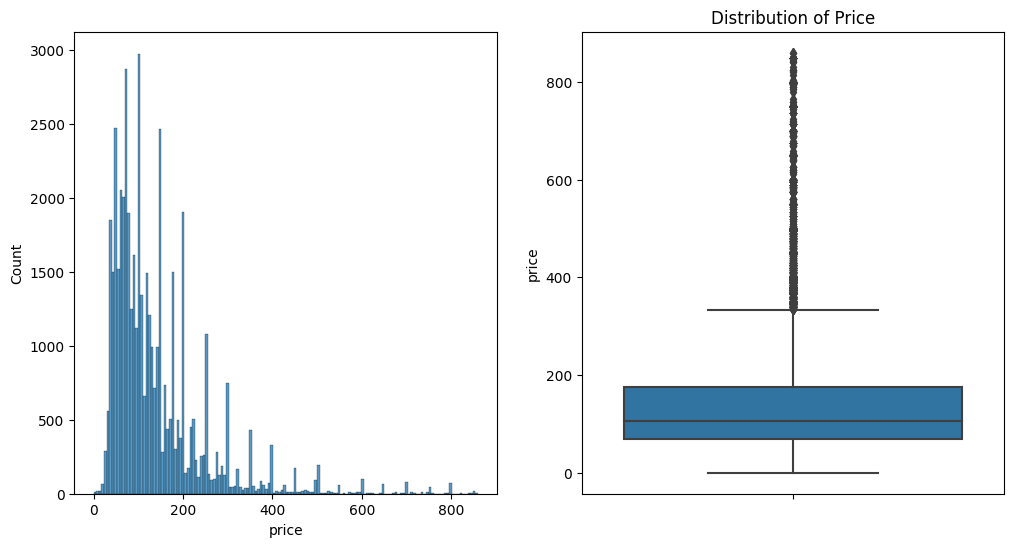

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(nyc['price'])

plt.subplot(1,2,2)
sns.boxplot(y=nyc['price'])
plt.title("Distribution of Price")
plt.show()

## Investigando correlações

Vamos investigar a correlação entre as variáveis numéricas

<AxesSubplot: >

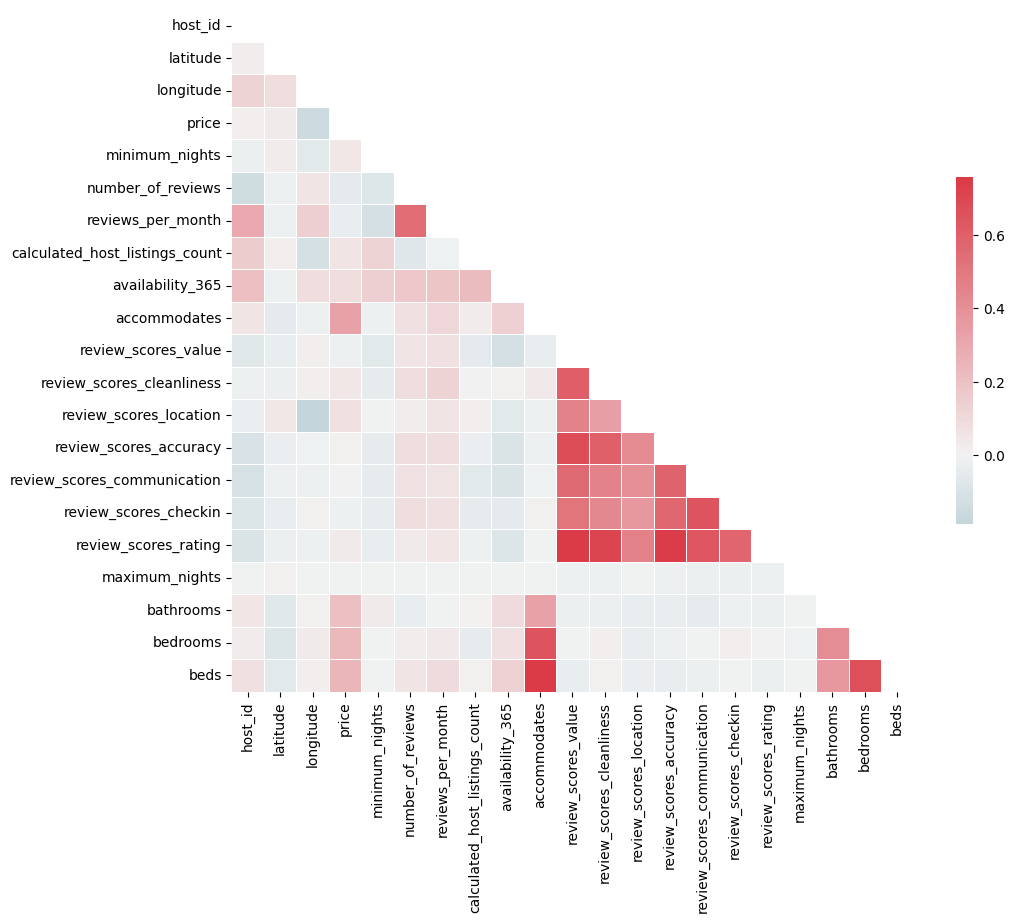

In [28]:
corr = nyc.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Percebe-se que os fatores de maior correlação são os `reviews` entre si. Porém, não estão relacionados com a variável de interesse `price`

Nota-se, porém, que a capacidade de acomodar, a quantidade de quartos, banheiros e camas pare ter forte correlação com o preço.

Além disso, é interessante notar que há uma correlação negativa entre longitude e preço. Ou seja, lugares mais ao sul de Nova Iorque tendem a ser mais caros.

Graficamente, podemos observar:

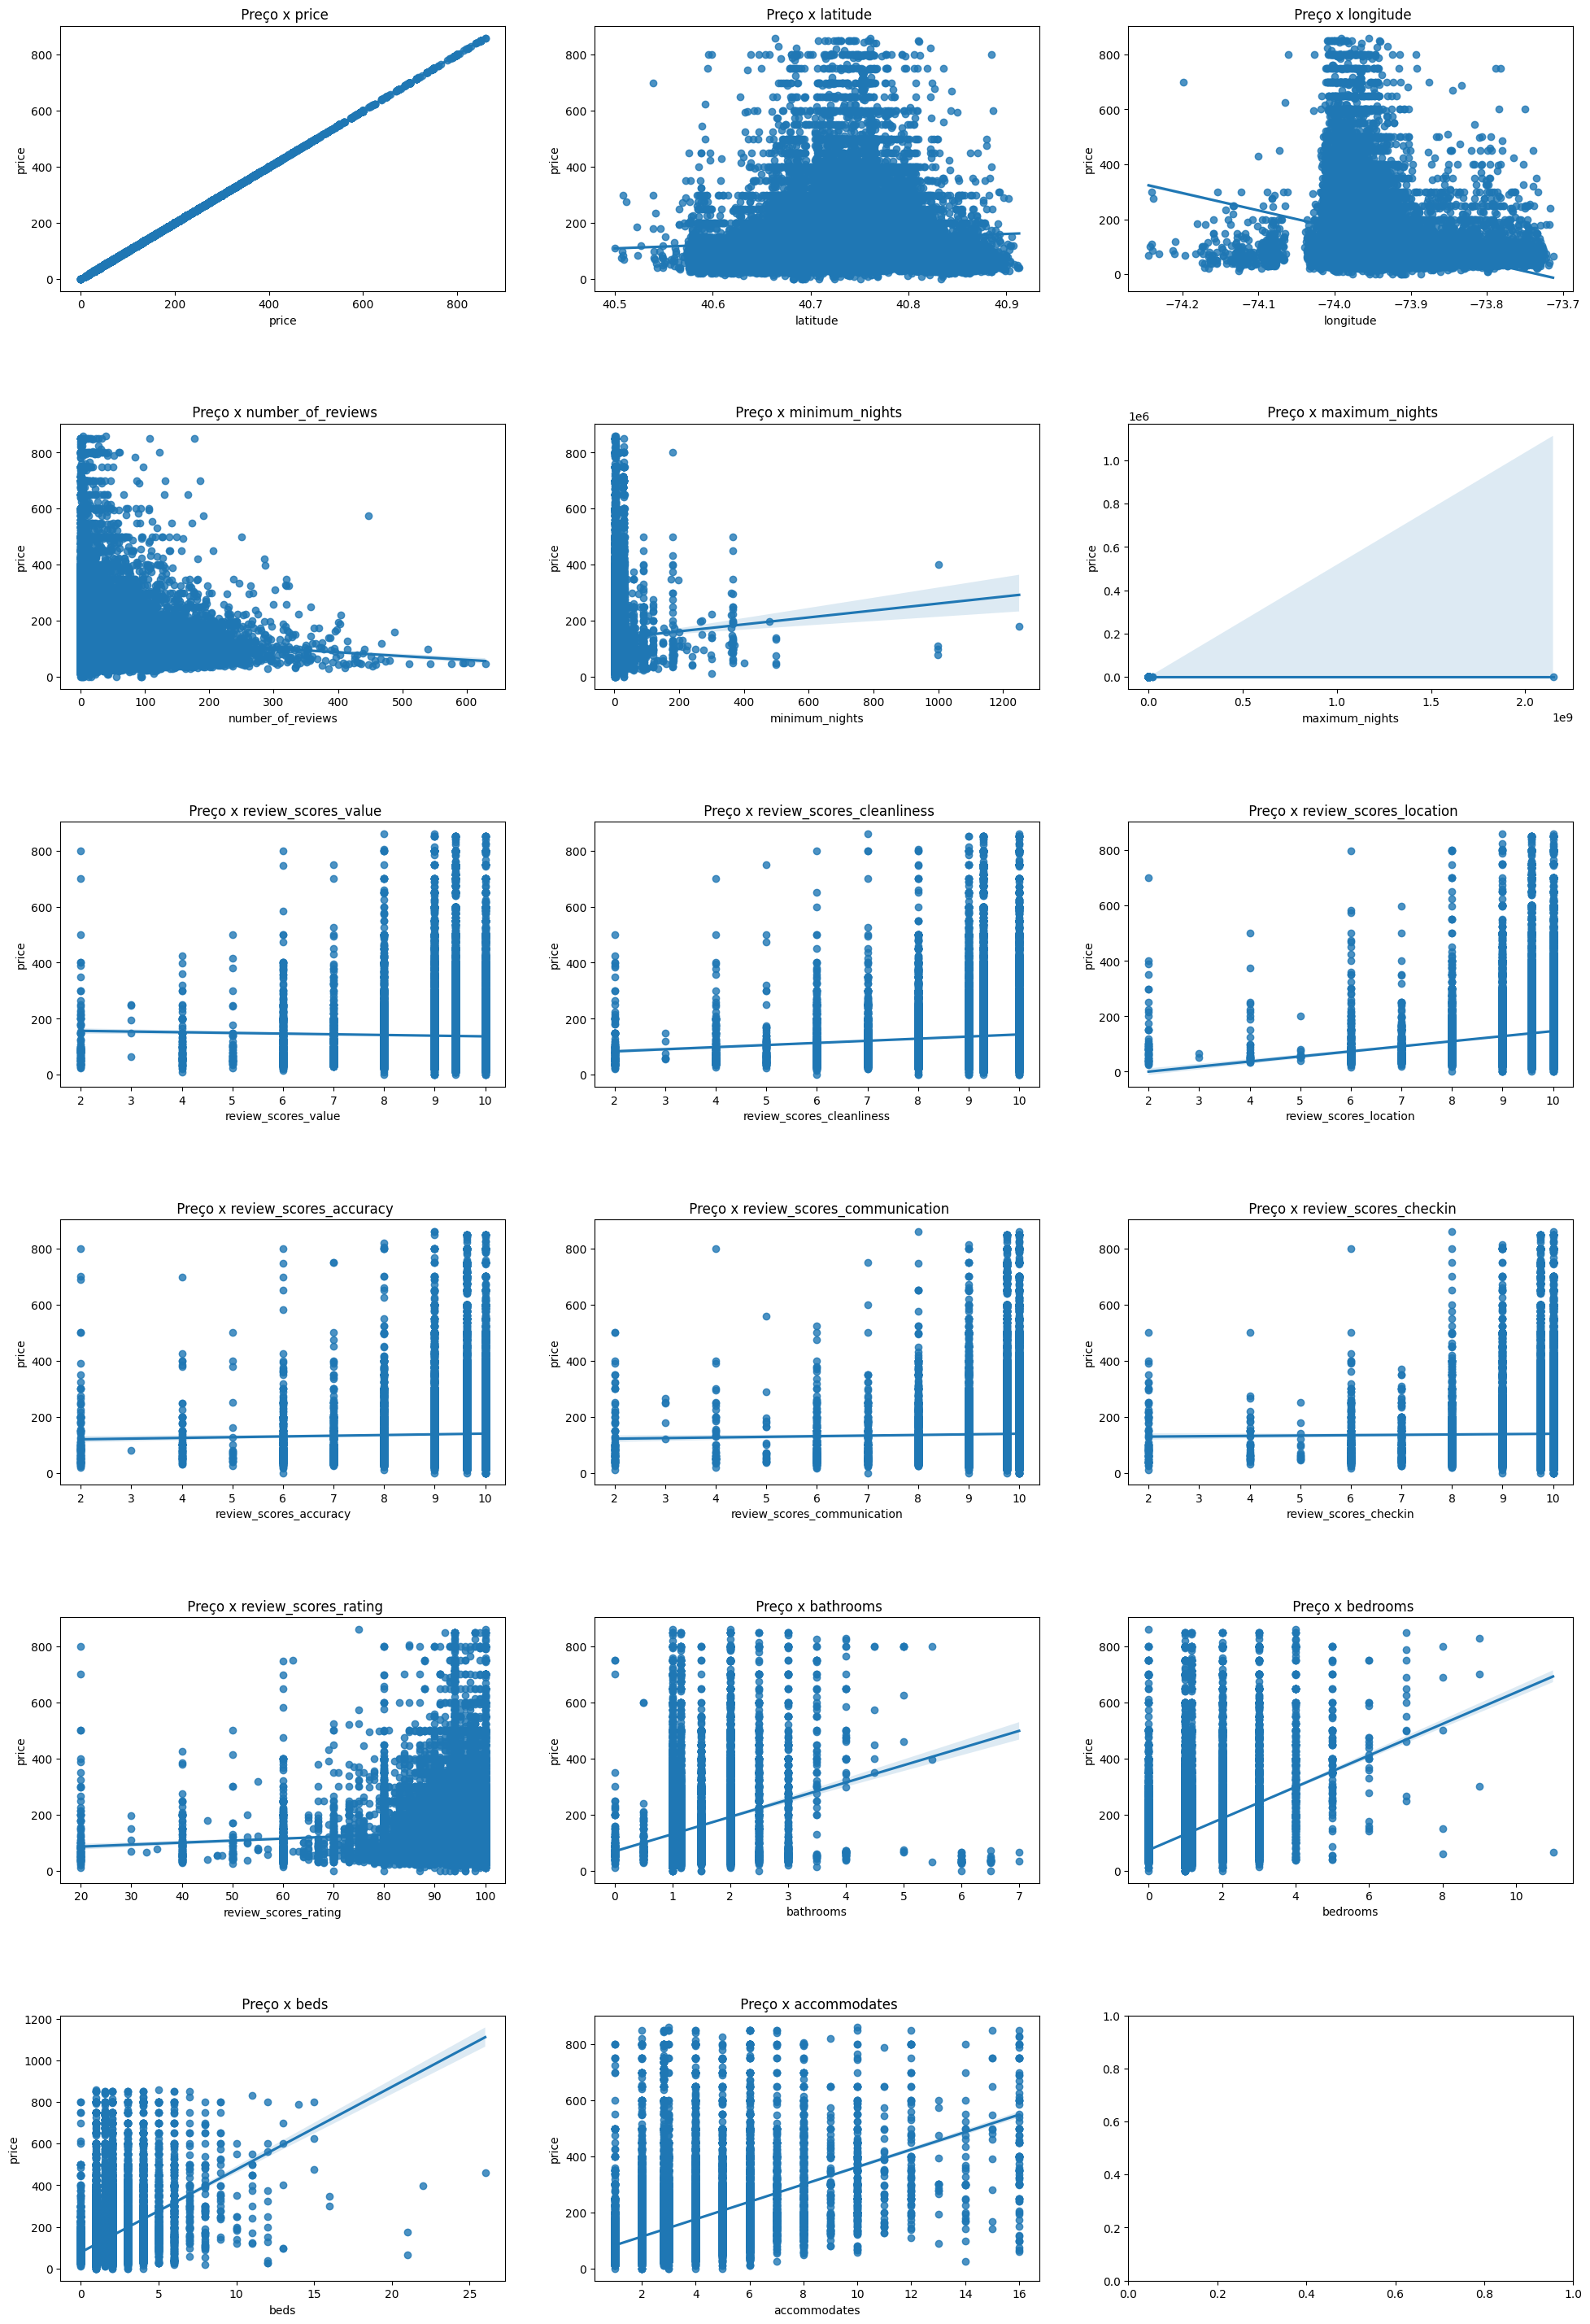

In [15]:
colunas_relevantes = ['price', 'latitude', 'longitude', 'number_of_reviews', 'minimum_nights', 'maximum_nights', 
                     'review_scores_value', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy', 
                     'review_scores_communication', 'review_scores_checkin', 'review_scores_rating',
                     'bathrooms', 'bedrooms', 'beds', 'accommodates', ]

newdf = nyc.loc[:, colunas_relevantes]
nrows = int(len(newdf.columns) / 3) + 1
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(24, 6*nrows))
fig.subplots_adjust(hspace=0.5)

for ax, name in zip(axes.flatten(), newdf.columns):
  
    sns.regplot(x=name, y='price', data=newdf, ax=ax)
    ax.set_title(f" Preço x {name}")

plt.show()

Para as variáveis categóricas, podemos ver como o preço se comporta diante de alguns agrupamentos. Para efeito de análise, vamos agrupar `neighbourhood_group` e `room_type` 

[]

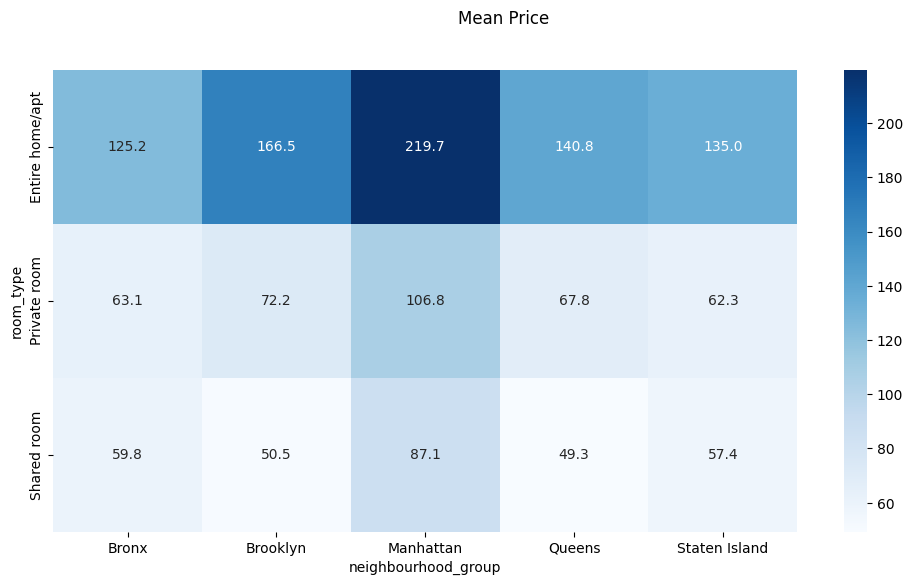

In [16]:
plt.figure(figsize=(12, 6))
df_pivot = nyc.pivot_table(values='price', index='room_type', columns='neighbourhood_group', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt='.1f', cmap='Blues')

plt.suptitle('Mean Price')
plt.plot()

Como era de se esperar, no geral, uma residência inteira é mais cara que um quarto privado, que é mais caro que um quarto compartilhado.

Agora que já temos uma noção minimamente melhor sobre nossa base de dados, podemos iniciar o estudo sobre os modelos de Machine Learning.


In [12]:
# filtrando apenas as linhas que possuem preço
nyc = nyc[nyc.price > 0]

# removendo colunas que não são relevantes para análise do preço
nyc.drop(columns=['name', 'host_id', 'host_name', 'reviews_per_month', 'host_response_rate'], inplace=True)

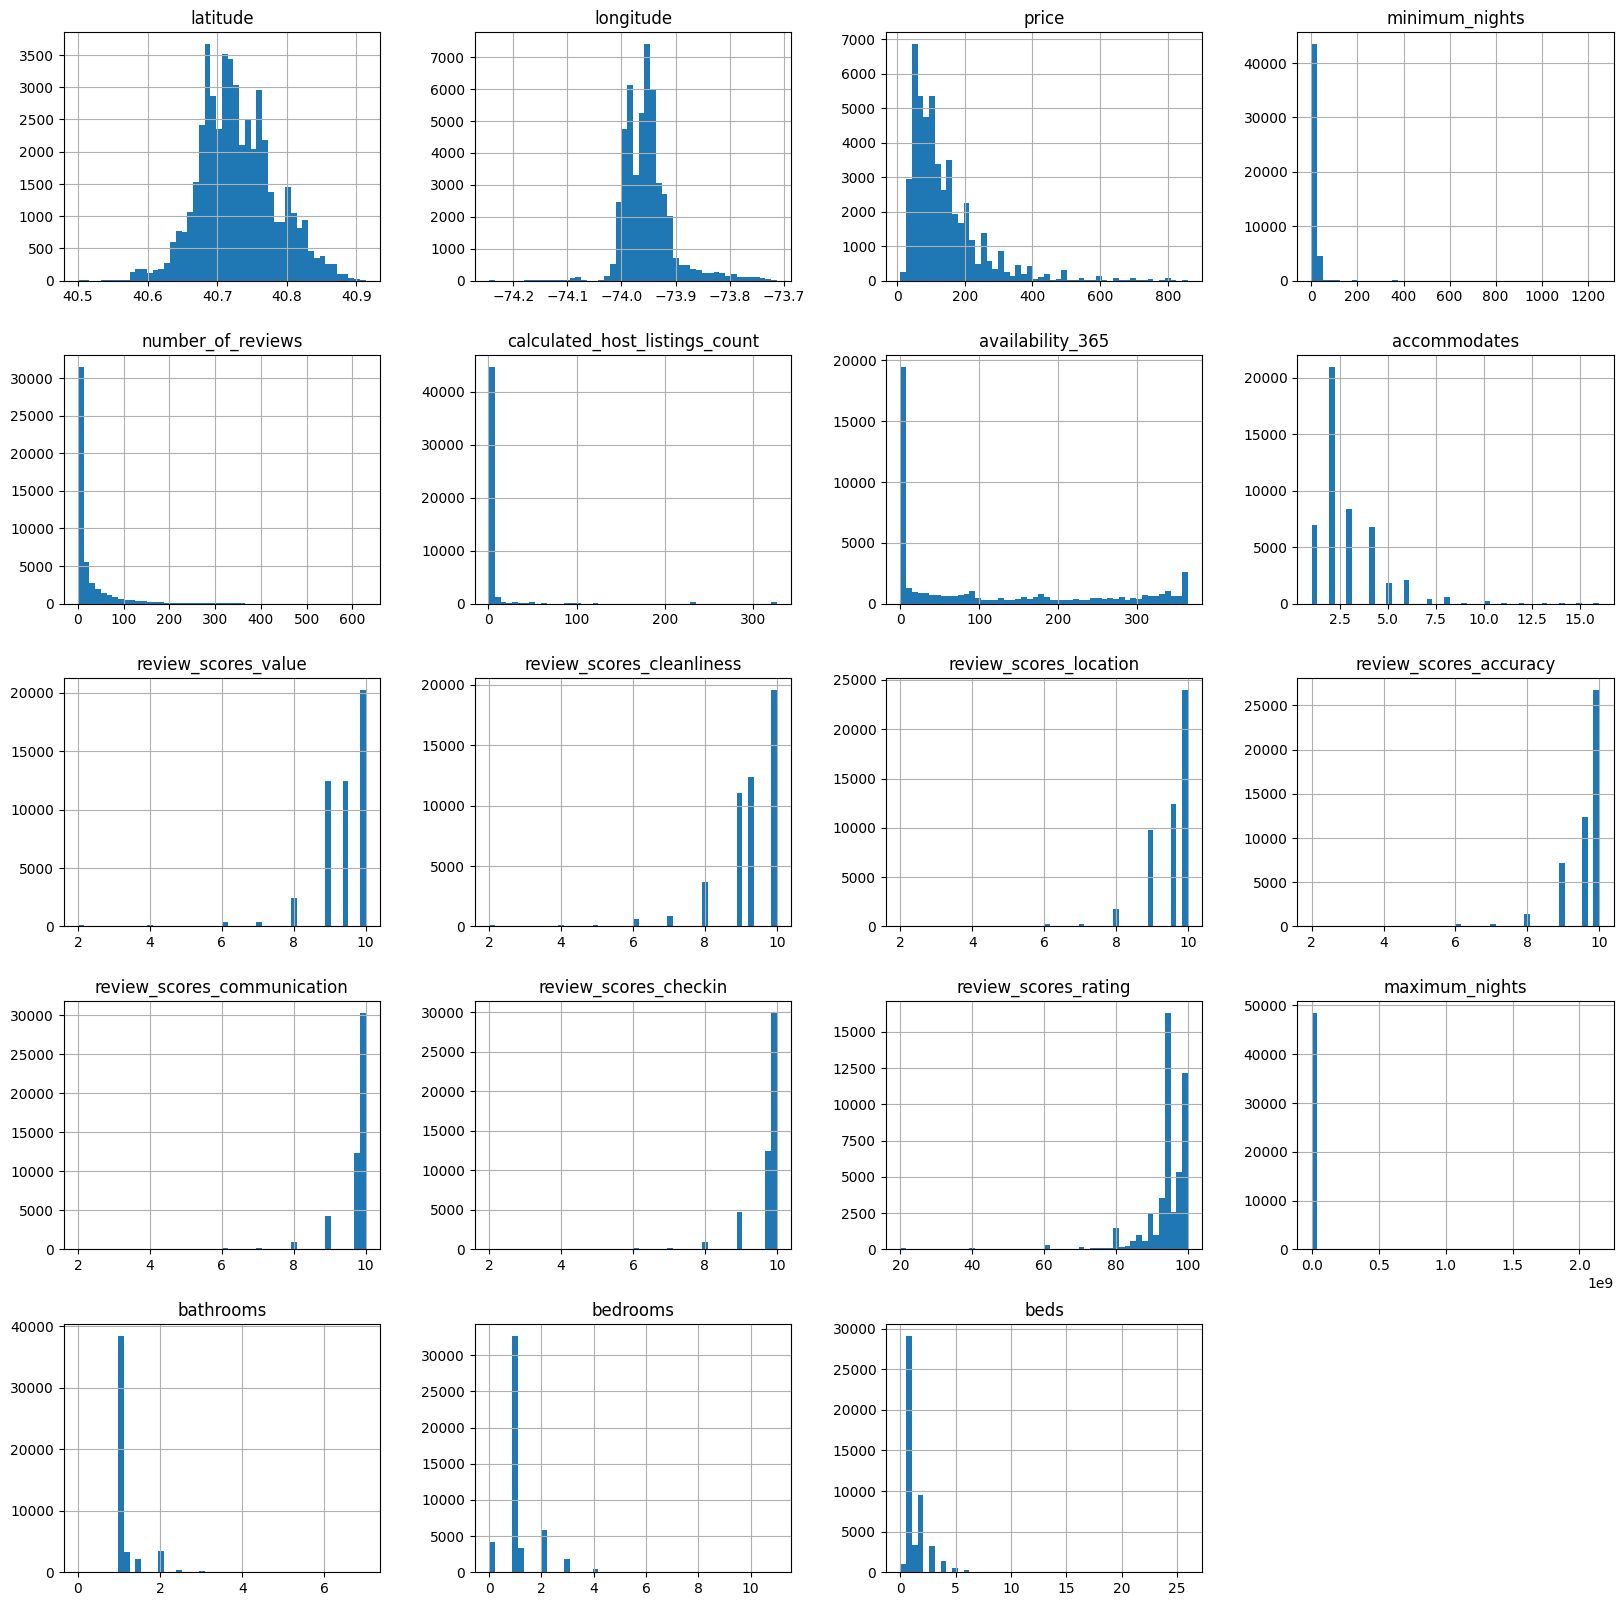

In [18]:
nyc.hist(bins=50, figsize=(20, 20))
plt.show()

Antes de se aprofundar no detalhamento das variáveis, vamos observar como os imóveis estão distribuídos por Nova Iorque.

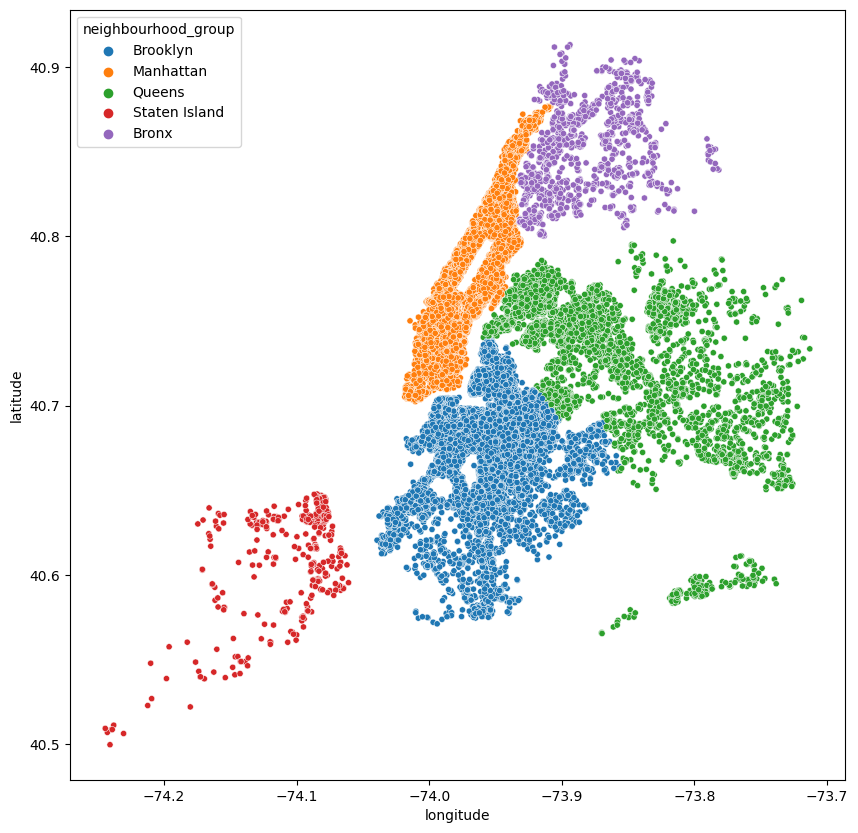

In [29]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=nyc,
    x='longitude', 
    y='latitude', 
    hue='neighbourhood_group',
    s=20
)

plt.show()

In [19]:
# Verificando colunas categóricas
nyc["neighbourhood"].value_counts()

Williamsburg          3905
Bedford-Stuyvesant    3696
Harlem                2649
Bushwick              2459
Hell's Kitchen        1943
                      ... 
Fort Wadsworth           1
Richmondtown             1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: neighbourhood, Length: 221, dtype: int64

In [20]:
nyc["neighbourhood_group"].value_counts()

Manhattan        21377
Brooklyn         20011
Queens            5650
Bronx             1088
Staten Island      370
Name: neighbourhood_group, dtype: int64

In [21]:
nyc["room_type"].value_counts()

Entire home/apt    25100
Private room       22242
Shared room         1154
Name: room_type, dtype: int64

In [22]:
nyc["host_response_time"].value_counts()

within an hour        36617
within a few hours     6655
within a day           4400
a few days or more      824
Name: host_response_time, dtype: int64

In [23]:
nyc["host_is_superhost"].value_counts()

f    39264
t     9232
Name: host_is_superhost, dtype: int64

Visualizando por Neighbourhood Group

In [24]:
nyc['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

Text(0.5, 0, '')

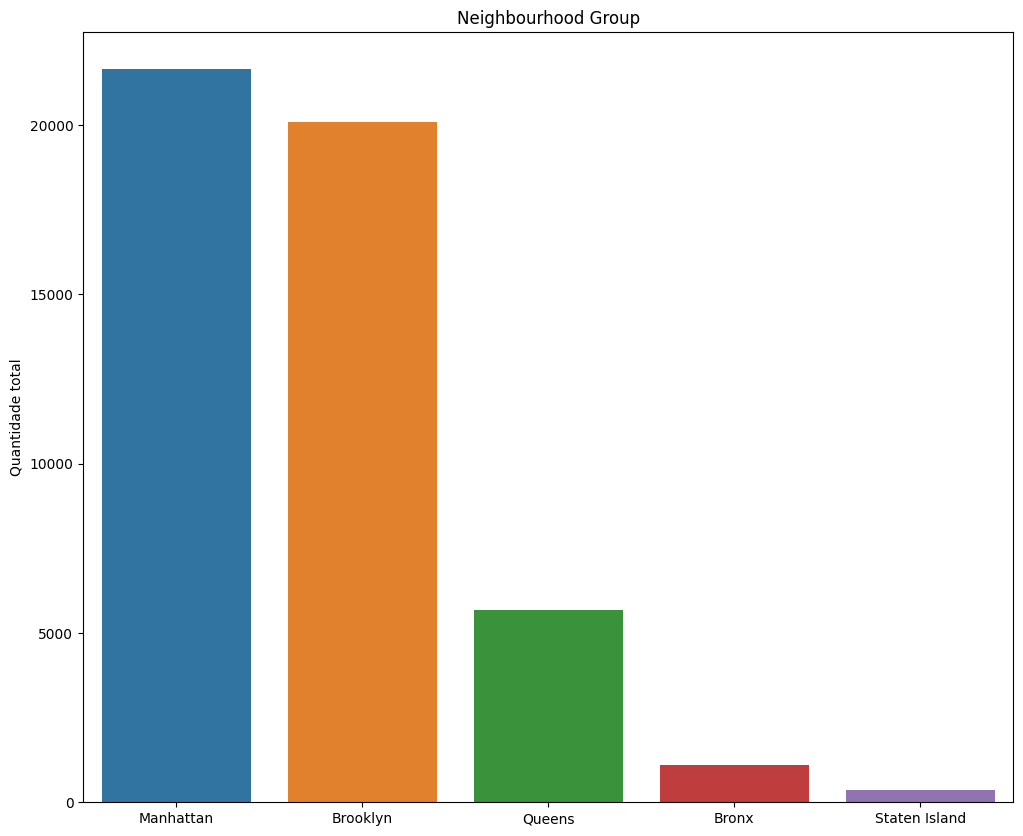

In [29]:
sns.countplot(data=nyc,
              x="neighbourhood_group",
              order = nyc['neighbourhood_group'].value_counts().index
             )
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.title("Neighbourhood Group")
plt.ylabel("Quantidade total")
plt.xlabel("")


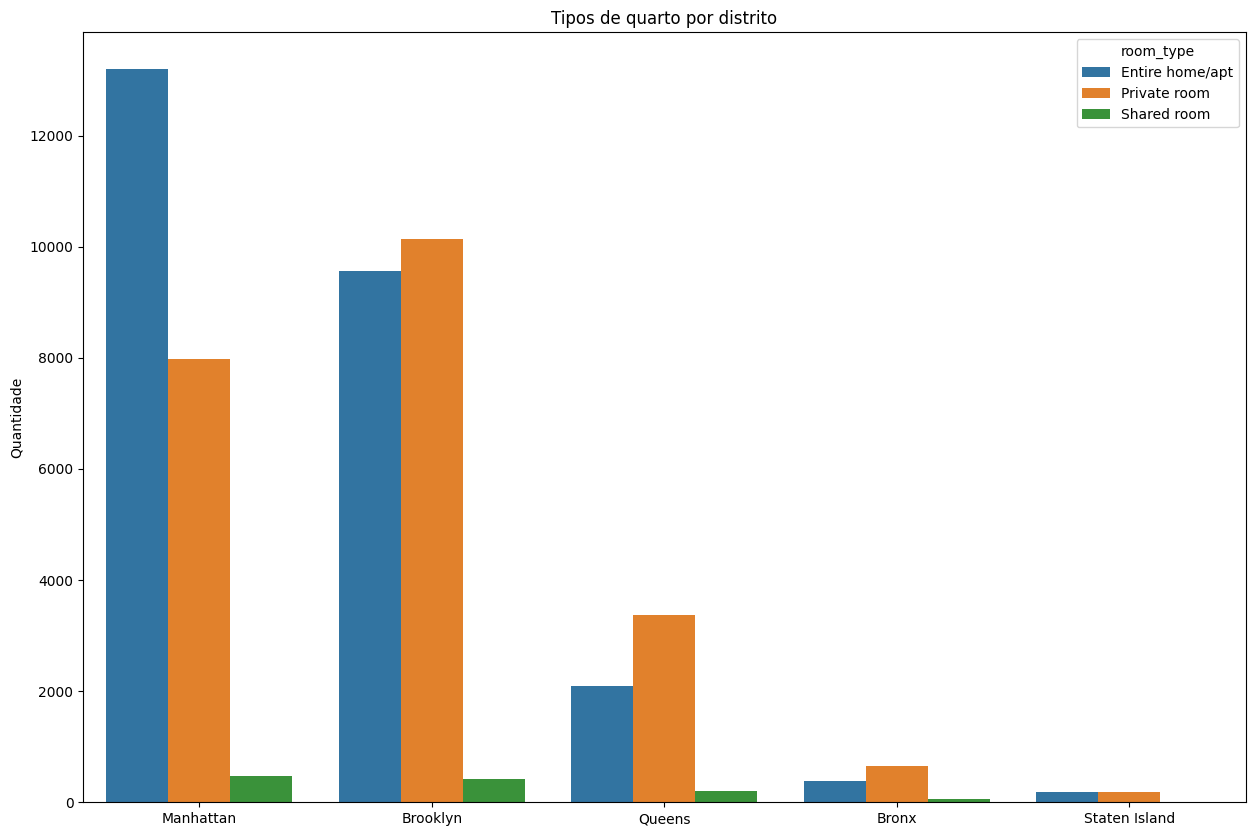

In [30]:
sns.countplot(
    data=nyc, 
    x="neighbourhood_group", 
    hue="room_type",
    hue_order=["Entire home/apt", "Private room", "Shared room"],
    order = nyc['neighbourhood_group'].value_counts().index
)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title("Tipos de quarto por distrito")
plt.xlabel("")
plt.ylabel("Quantidade")
plt.show()

Percebe-se que nos bairros de maior procura, há uma proporção bastante significativa de quartos privados em relação ao imóvel todo. Para bairros de menor procura, a relação de Quartos Privados para Imóvel todo é menor ou próximo a 1.

In [31]:
# Explorando o top 10 dos bairros que mais aparecem
top10_neighbours = list(nyc["neighbourhood"].value_counts().head(10).index)
top10_neighbours

['Williamsburg',
 'Bedford-Stuyvesant',
 'Harlem',
 'Bushwick',
 'Upper West Side',
 "Hell's Kitchen",
 'East Village',
 'Upper East Side',
 'Crown Heights',
 'Midtown']

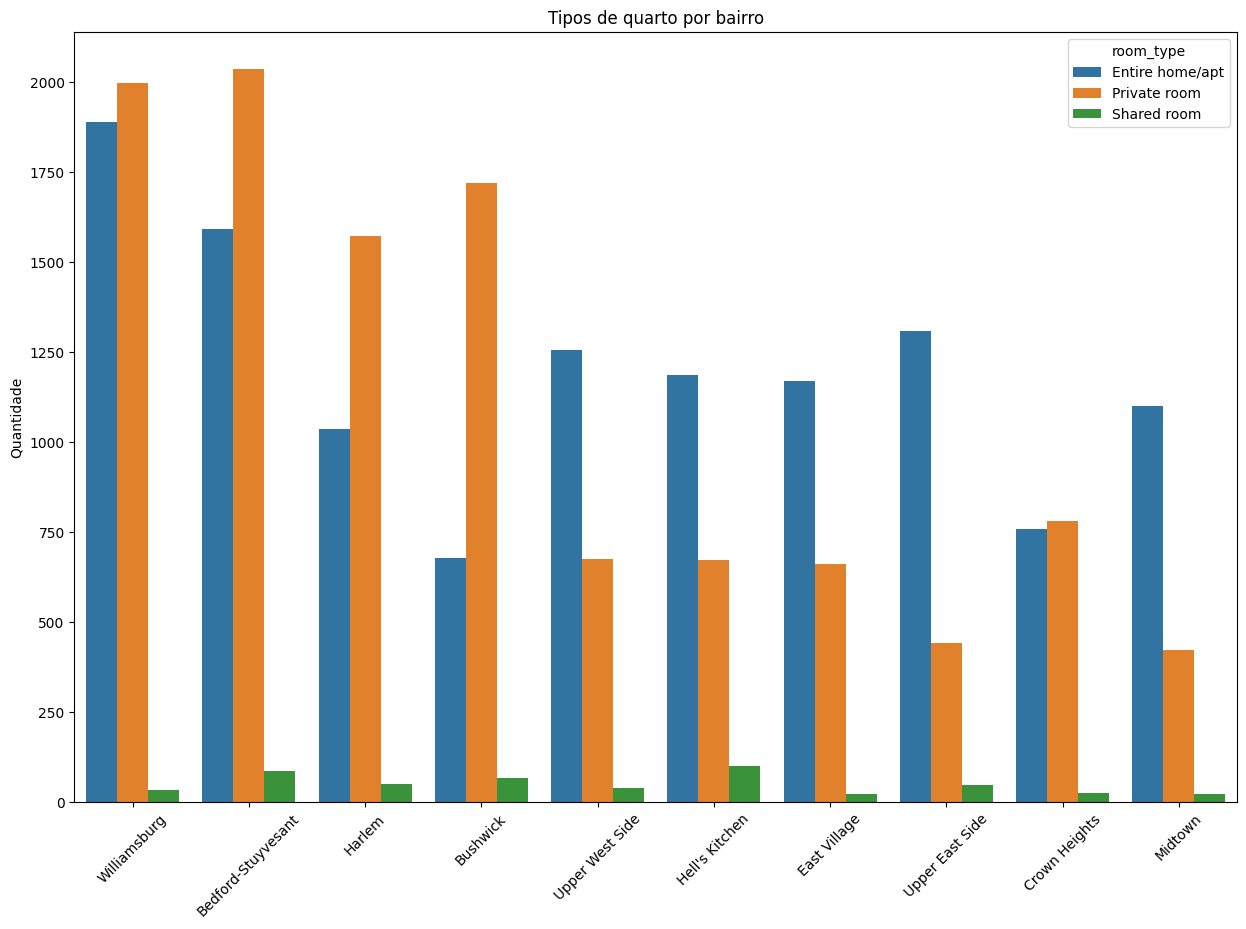

In [33]:
nyc_top10 = nyc[nyc["neighbourhood"].isin(top10_neighbours)]

sns.countplot(
    data=nyc_top10, 
    x="neighbourhood", 
    hue="room_type",
    hue_order=["Entire home/apt", "Private room", "Shared room"],
    order = nyc_top10['neighbourhood'].value_counts().index
)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title("Tipos de quarto por bairro")
plt.xlabel("")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.show()

Neste gráfico, fica mais evidente a maior relação entre quartos privados e o imóvel todo nos bairros de maior procura, o que é bastante justificável, refletindo uma tendência do mercado em se adaptar à demanda da região.

# Machine Learning
## Preparando o dataframe

Vamos remover algumas colunas que não serão úteis para o modelo. E vamos tratar outras, para que possam ser computadas.

### Separando X e y

In [25]:
# Variável dependente
nyc_labels = nyc["price"].copy()

# Variáveis independentes
nyc_x = nyc.drop(columns=["price", "neighbourhood"], axis="columns").copy()

In [35]:
nyc_x.head(3).transpose()

id,2539,2595,3647
neighbourhood_group,Brooklyn,Manhattan,Manhattan
latitude,40.64749,40.75362,40.80902
longitude,-73.97237,-73.98377,-73.9419
room_type,Private room,Entire home/apt,Private room
minimum_nights,1,1,3
number_of_reviews,9,45,0
calculated_host_listings_count,6,2,1
availability_365,365,355,365
property_type,Apartment,Apartment,Apartment
accommodates,2.823851,2.0,2.0


### Pipelines para preparação dos dados

Antes de dividir a base de dados em treinamento e testes, algumas mudanças devem ser feitas para que os modelos construídos possam desempenhar melhor em cima de cada uma das *features*. As variáveis independentes serão serapadas em dois tipos: numéricas e categóricas. Para cada uma dessas variáveis, será aplicado um processo de transformação:

- **Numéricas**: Todas as variáveis numéricas deverão ser ajustadas para uma mesma escala, isto é, terão a mesma ordem de grandeza (evitar que uma seja da ordem $10^{-3}$ e outra seja da ordem $10^4$, por exemplo).
- **Categóricas**: As variáveis categóricas dessa base de dados não possuem ordem ou "grau de intensidade" entre si (por exemplo, na coluna `room_type` os tipos de quarto não possuem relação de um ser melhor/pior que o outro), logo, será aplicado um codificador chamado de `OneHotEncoder`, que gera uma coluna binária para cada tipo dessa coluna, atribuindo $1$ à correspondente e $0$ às demais, evitando a existência de "pesos" entre esses atributos.

Para aplicar as transformações acima, serão criados duas pipelines (uma para cada tipo de variável) e, em seguida, unidas em outra pipeline que recebe os dados e retorna o resultado final das transformações.

In [36]:
scaler = StandardScaler()
encoder_1hot = OneHotEncoder(categories="auto", sparse=False)

# Pipeline para variáveis numéricas
num_pipeline = Pipeline([
    ("std_scaler", scaler)
])

# Pipeline para variáveis categóricas
cat_pipeline = Pipeline([
    ("cat_encoder", encoder_1hot)
])

In [37]:
# Separa colunas categóricas e numéricas
cat_attrs = ["neighbourhood_group", "room_type", "host_response_time", "property_type", "host_is_superhost"]
num_attrs = [col for col in list(nyc_x.columns) if col not in cat_attrs]

# Une pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("cat", cat_pipeline, cat_attrs)
])

# Aplica pipeline completo às variáveis independentes
nyc_prepared = full_pipeline.fit_transform(nyc_x)

### Divisão dos dados em treinamento e testes

Agora é necessário dividir a base de dados em treinamento e teste. Aqui, será utilizada uma divisão aleatória com $30\%$ dos dados sendo para testes e $70\%$ para treinamento.

In [38]:
# Divide os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    nyc_prepared,
    nyc_labels,
    test_size=0.3,
    random_state=RANDOM_SEED,
)

# Construindo modelos preditivos

Neste notebook, serão testados alguns modelos de *machine learning* para comparar o desempenho de cada um e fazer um comparativo entre eles. Esses modelos serão:

1. Regressão Linear
2. Regressão Lasso
3. Regressão Ridge
4. ElasticNET
5. Decision Tree Regressor
6. Random Forest Regressor
7. K-Neighbours Regressor
8. Support Vector Machines

Para cada modelo, serão feitas duas avaliações: a primeira com uma implementação simples e direta do modelo e a segunda com uma otimização de hiperparâmetros para comparar as diferenças de desempenho. Em seguida, será aplicada uma técnica chamada *cross validation*, na qual o conjunto de treinamento é fracionado em vários subconjuntos, e cada modelo é treinado com uma diferente combinação desses subconjuntos de dados e então é validado em relação às frações restantes. A imagem abaixo, extraída da [página do scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html), exemplifica esse processo:

<img src="./img/grid_search_cross_validation.png"></img>

In [39]:
# Função que retorna o modelo com os melhores parâmetros
# selecionados via grid search
def get_best_model(model, params, model_name, X_train=X_train, y_train=y_train, cv=5, n_jobs=-1):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=n_jobs
    )
    # Encontra os melhores parâmetros
    t0 = perf_counter()
    grid_search.fit(X_train, y_train)
    t1 = perf_counter()
    
    # Exibe tempo gasto
    print(f"Tempo gasto para busca de parâmetros de {model_name}: {t1 - t0:.2f}s")
    
    # Exibe melhores parâmetros
    print(f"Melhores parâmetros de {model_name}: {grid_search.best_params_}\n")
    
    return grid_search.best_estimator_


def compare_models_results(model1, model2, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Modelo sem ajustes
    model1.fit(X_train, y_train)
    y_pred1 = model1.predict(X_test)
    print("============= SEM AJUSTES =============")
    print(f"R²   = {r2_score(y_test, y_pred1)}")
    print(f"RMSE = {sqrt(mean_squared_error(y_test, y_pred1))}\n")
    
    # Modelo com ajustes
    model2.fit(X_train, y_train)
    y_pred2 = model2.predict(X_test)
    print("============= COM AJUSTES =============")
    print(f"R²   = {r2_score(y_test, y_pred2)}")
    print(f"RMSE = {sqrt(mean_squared_error(y_test, y_pred2))}")
    
    return y_pred1, y_pred2

In [40]:
def get_scores(model, X_train=X_train, y_train=y_train, cv=10, n_jobs=-1):
    model_scores = cross_val_score(
        estimator=model,
        X=X_train,
        y=y_train,
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=n_jobs,
    )
    return np.sqrt(-model_scores)


def display_scores(scores):
    print('Média         =', scores.mean())
    print('Desvio padrão =', scores.std())


def plot_test_results(y_test, y_pred, title):
    plt.plot(y_test, y_pred, 'o', alpha=0.5, color="green")
    plt.xlabel("Valor real nos testes")
    plt.ylabel("Valor previsto nos testes")
    plt.title(title)
    plt.show()

### Regressão Linear

A regressão linear consiste em um função linear que calcula uma soma ponderada dos atributos de entrada e resulta em uma saída numérica. Matematicamente:

$$\hat{y}=\theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$$

- $\hat{y}$ é o valor previsto
- $n$ é o número de atributos ou características
- $x_k$ é o valor do k-*ésimo* atributo
- $\theta_i$ é o parâmetro do modelo $j$

In [41]:
%%time

reg_linear = LinearRegression()
params_rl = {
    "fit_intercept": [True, False],
    "copy_X": [True, False]
}

model_reg_linear = get_best_model(reg_linear, params_rl, "Regressão Linear")

Tempo gasto para busca de parâmetros de Regressão Linear: 8.56s
Melhores parâmetros de Regressão Linear: {'copy_X': True, 'fit_intercept': False}

CPU times: total: 828 ms
Wall time: 8.56 s


#### Validação cruzada

In [42]:
scores_rl = get_scores(model_reg_linear)

# Exibe resultados
display_scores(scores_rl)

Média         = 136496684939.81046
Desvio padrão = 233562397927.8688


O modelo de regressão linear com certeza não conseguiu fazer um bom ajuste aos dados, os valores de RMSE e desvio padrão estão muito elevados. A seguir, serão trabalhadas 3 regularizações da Regressão Linear: *Lasso*, *Ridge* e *Elastic Net*.

### Regressão Lasso

Uma forma de diminuir o *overfitting* de uma regressão linear é aplicar uma regularização do modelo, que consiste em diminuir o seu grau de liberdade (restringindo os pesos do modelo). A primeira maneira tratada aqui é a Regressão Lasso (*Least Absolute Shrinkage and Selection Operator Regression*), cujo comportamento tende a zerar os pesos de características menos importantes.

In [43]:
%%time

lasso = Lasso(random_state=RANDOM_SEED)
alpha_list = np.geomspace(1e-2, 10, num=4).tolist()
tol_list = np.geomspace(1e-5, 1e-2, num=4).tolist()
params_lasso = {
    "alpha": alpha_list,
    "selection": ["cyclic", "random"],
    "tol": tol_list
}

model_lasso = get_best_model(lasso, params_lasso, "Regressão Lasso")

Tempo gasto para busca de parâmetros de Regressão Lasso: 38.20s
Melhores parâmetros de Regressão Lasso: {'alpha': 0.01, 'selection': 'cyclic', 'tol': 0.01}

CPU times: total: 4.55 s
Wall time: 38.2 s


#### Validação cruzada

In [44]:
scores_lasso = get_scores(model_lasso)

# Exibe resultados
display_scores(scores_lasso)

Média         = 75.54321557642065
Desvio padrão = 2.1860495807229827


#### Validação com dados de teste

In [45]:
# Compara modelos de regressão lasso sem e com ajustes de parâmetros
_, y_pred_lasso = compare_models_results(lasso, model_lasso)

============= SEM AJUSTES =============
R²   = 0.4685632316155889
RMSE = 79.69136287597465

============= COM AJUSTES =============
R²   = 0.49867931874200555
RMSE = 77.40041076194832


### Regressão Ridge

A Regressão Ridge é outra dessas formas de regularização, que consiste em adicionar à função de custo um termo de regularização igual à $\alpha\sum_n^{i=1} \theta_i^2$, em que $\alpha$ é o hiperparâmetro que controla essa regularização. Para $\alpha=0$, tem-se apenas uma Regressão Linear, enquanto que $\alpha$ muito grande resulta em pesos muito próximos de zero.

In [46]:
%%time

ridge = Ridge(random_state=RANDOM_SEED)
solvers = ["auto", "svd", "lsqr", "sparse_cg"]
params_ridge = {
    "alpha": alpha_list,
    "tol": tol_list,
    "solver": solvers
}

model_ridge = get_best_model(ridge, params_ridge, "Regressão Ridge")

Tempo gasto para busca de parâmetros de Regressão Ridge: 38.66s
Melhores parâmetros de Regressão Ridge: {'alpha': 0.01, 'solver': 'sparse_cg', 'tol': 0.01}

CPU times: total: 3.5 s
Wall time: 38.7 s


#### Validação Cruzada

In [47]:
scores_ridge = get_scores(model_ridge)

# Exibe resultados
display_scores(scores_ridge)

Média         = 76.07249057997313
Desvio padrão = 2.1903984145223947


#### Validação com dados de teste

In [48]:
# Compara modelos de regressão ridge sem e com ajustes de parâmetros
_, y_pred_ridge = compare_models_results(ridge, model_ridge)

============= SEM AJUSTES =============
R²   = 0.49863942825108654
RMSE = 77.40349010724664

============= COM AJUSTES =============
R²   = 0.4966127608889088
RMSE = 77.55977774148724


### ElasticNet

A terceira regularização da Regressão Linear abordada aqui é a *Elastic Net*, que nada mais é que uma combinação das duas regularizações anteriores, isto é, existe um parâmetro $r$ que varia de zero a um que, quando $r=0$, a Elastic Net se torna uma Regressão Ridge, ao passo que $r=1$ trata-se de uma Regressão Lasso. Quando $0<r<1$, tem-se uma mixagem de Ridge e Lasso.

In [49]:
%%time

elastic_net = ElasticNet(random_state=RANDOM_SEED)
params_enet = {
    "alpha": alpha_list,
    "l1_ratio": [0, 0.25, 0.5, 0.75, 1],
}

model_enet = get_best_model(elastic_net, params_enet, "Regressão ElasticNET")

Tempo gasto para busca de parâmetros de Regressão ElasticNET: 57.14s
Melhores parâmetros de Regressão ElasticNET: {'alpha': 0.01, 'l1_ratio': 1}

CPU times: total: 4.12 s
Wall time: 57.1 s


#### Validação cruzada

In [50]:
scores_enet = get_scores(model_enet)

# Exibe resultados
display_scores(scores_enet)

Média         = 75.54343007260312
Desvio padrão = 2.1855040605195217


#### Validação nos dados de teste

In [51]:
# Compara modelos de regressão elastic net sem e com ajustes de parâmetros
_, y_pred_enet = compare_models_results(elastic_net, model_enet)

============= SEM AJUSTES =============
R²   = 0.4108200900464981
RMSE = 83.90916894184217

============= COM AJUSTES =============
R²   = 0.49865698902845845
RMSE = 77.40213451863748


### Decision Tree Regression

Árvore de Decisão (*Decision Trees*) é uma maneira, como o próprio nome diz, de se tomar uma decisão. É como um mapa que traça uma série de escolhas até que se chegue a uma decisão final. A árvore começa com um único *nó*, que se divide nos resultados possíveis, os quais podem levar as nós adicionais e assim por diante, conforme a ilustração abaixo (extraída [daqui](https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm)):

<img src="./img/decision-tree.png"></img>

Algumas terminologias importantes:

- Nó Raiz: Onde a árvore de decisão começa, representa o *dataset*
- Nó Folha: São o nó de resultado e a árvore não pode ser mais segregada nesse nó.
- Divisão: A divisão é o processo de divisão do nó de decisão/nó raiz em subnós conforme as condições imputadas.
- Ramo/Sub-árvore: Uma árvore formada pela divisão da árvore.
- Poda: A poda é o processo de remover os galhos indesejados da árvore.
- Nó pai/filho: o nó raiz da árvore é chamado de nó pai e os outros nós são chamados de nós filhos.

Para aplicar o *grid search*, serão testados diferentes valores de profundidade (altura) da árvore, do número mínimo de amostras necessárias para dividir um nó interno e do número mínimo de amostras necessárias para estar em um nó folha.

In [52]:
%%time

decision_tree = DecisionTreeRegressor(random_state=RANDOM_SEED)
params_tree = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
}

model_tree = get_best_model(decision_tree, params_tree, "Árvore de Decisão")

Tempo gasto para busca de parâmetros de Árvore de Decisão: 35.24s
Melhores parâmetros de Árvore de Decisão: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}

CPU times: total: 4.47 s
Wall time: 35.2 s


#### Validação cruzada

In [53]:
scores_tree = get_scores(model_tree)

# Exibe resultados
display_scores(scores_tree)

Média         = 71.88089109531728
Desvio padrão = 2.385802525680517


#### Validação nos dados de teste

In [54]:
# Compara modelos de árvore de decisão sem e com ajustes de parâmetros
_, y_pred_tree = compare_models_results(decision_tree, model_tree)

============= SEM AJUSTES =============
R²   = 0.28028285122811236
RMSE = 92.73984811363123

============= COM AJUSTES =============
R²   = 0.5554442127160547
RMSE = 72.88675058110513


In [55]:
# Avaliando features mais importantes
model_tree.feature_importances_

array([4.70815027e-02, 9.09808658e-02, 6.84820224e-03, 1.19672541e-02,
       1.62824999e-02, 1.63215781e-02, 3.55987263e-02, 0.00000000e+00,
       1.41827021e-03, 3.13177521e-04, 0.00000000e+00, 0.00000000e+00,
       5.65302744e-04, 7.88975092e-04, 2.26138147e-03, 1.51457665e-01,
       8.49624743e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.81687431e-02, 0.00000000e+00, 0.00000000e+00, 4.14900257e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.13554031e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.00215679e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.29249436e-04, 0.00000000e+00, 0.00000000e+00, 1.78195382e-04,
      

### Random Forest Regressor

Random Forest (Floresta Aleatória) é um tipo de de algoritmo supervisionado de *machine learning*, baseado em *ensemble learning* (onde se juntam diferentes tipos de algoritmos ou o mesmo algoritmo múltiplas vezes para formar um modelo de predição mais poderoso). O algoritmo do random forest combina múltiplos algoritmos do mesmo tipo, sendo composto por várias Árvores de Decisão, as quais formam uma floresta de árvores, ou seja, a Random Forest.

O Algoritmo da Random Forest pode ser resumido nestes seguintes passos:

1. Escolha $N$ dados aleatoriamente, com repetição, do dataset.
2. Construa uma Árvore de Decisão com base nesses $N$ valores.
3. Escolha o número $n$ de Árvores que você deseja em um sua floresta e repita os passos 1 e 2 $n$ vezes.
4. O resultado final será a média do valor previsto em cada Árvore da Floresta (para o caso de **regressão**).

In [56]:
%%time

forest = RandomForestRegressor(random_state=RANDOM_SEED)
params_forest = [
    {
        'n_estimators': [10, 30, 50],
#         'max_features': [15, 20, 25],
    },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
#         'max_features': [3, 4],
    }
]

model_forest = get_best_model(forest, params_forest, "Random Forest Regressor")

Tempo gasto para busca de parâmetros de Random Forest Regressor: 69.65s
Melhores parâmetros de Random Forest Regressor: {'n_estimators': 50}

CPU times: total: 14.9 s
Wall time: 1min 9s


#### Validação cruzada

In [57]:
scores_forest = get_scores(model_forest)

# Exibe resultados
display_scores(scores_forest)

Média         = 65.10906125472471
Desvio padrão = 2.172081495611346


#### Validação nos dados de teste

In [58]:
# Compara modelos de floresta aleatória sem e com ajustes de parâmetros
_, y_pred_forest = compare_models_results(forest, model_forest)

============= SEM AJUSTES =============
R²   = 0.6368656916475346
RMSE = 65.8747675956467

============= COM AJUSTES =============
R²   = 0.6336080002427014
RMSE = 66.16959035227171


#### Top 15 *features* mais importantes

In [59]:
# Pega atributos separados pelo OneHot
cat_one_hot_attrs = list(
    full_pipeline.named_transformers_.cat.get_feature_names_out(cat_attrs)
)

# Importância das features do modelo
features = model_forest.feature_importances_

# Junta atributos numéricos e categóricos
attributes = num_attrs + cat_one_hot_attrs

# Merge da importância das features com os atributos
feature_importances = sorted(zip(features, attributes), reverse=True)

In [60]:
# Separa nomes dos valores
feature_names = list(map(lambda x: x[1], feature_importances))
feature_values = list(map(lambda x: x[0], feature_importances))

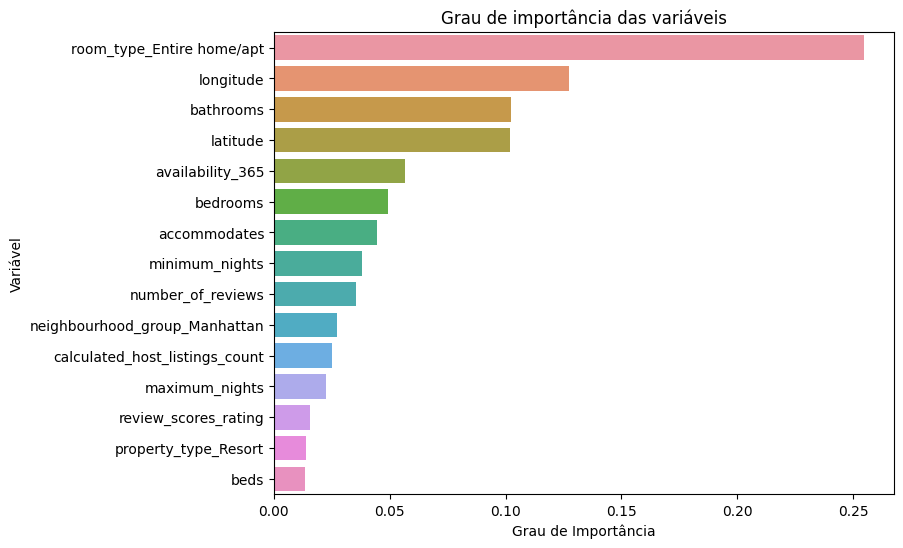

In [61]:
# Plota features mais importantes
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_values[:15], y=feature_names[:15])
plt.xlabel('Grau de Importância')
plt.ylabel('Variável')
plt.title("Grau de importância das variáveis")
plt.show()

A partir do gráfico acima, pode-se notar que a *feature* mais importante é o tipo de quarto, no caso uma casa ou apartamento inteiro, é o maior determinante no preço. Em seguida, vem a localização e número de banheiros, disponibilidade no ano e número de quartos e capacidade de acomodação.

### K-Neighbors Regressor

O algoritmo de k-vizinhos mais próximos (*K–Nearest Neighbours* – KNN) é um método usado tanto para classificação quanto para regressão. Nos dois casos, a entrada consiste nos $k$ exemplos de treinamento mais próximos no espaço de recursos, quanto a saída depende se é uma regressão ou uma classificação. De forma simplificada, O kNN, no caso da regressão, calcula a previsão do valor numérico real de uma nova amostra, considerando a média dos k vizinhos mais próximos.

In [62]:
%%time

knn = KNeighborsRegressor()
params_knn = {
    "n_neighbors": [5, 10, 15],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

model_knn = get_best_model(knn, params_knn, "kNN Regressor")

Tempo gasto para busca de parâmetros de kNN Regressor: 140.81s
Melhores parâmetros de kNN Regressor: {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}

CPU times: total: 516 ms
Wall time: 2min 20s


#### Validação cruzada

In [63]:
scores_knn = get_scores(model_knn)

# Exibe resultados
display_scores(scores_knn)

Média         = 68.34238701281217
Desvio padrão = 1.8548533057194678


#### Validação nos dados de teste

In [64]:
# Compara modelos de knn sem e com ajustes de parâmetros
_, y_pred_knn = compare_models_results(knn, model_knn)

============= SEM AJUSTES =============
R²   = 0.54529195196518
RMSE = 73.7143050265747

============= COM AJUSTES =============
R²   = 0.6006579013323843
RMSE = 69.0809025231277


### Support Vector Machine

Máquina de Vetores de Suporte (*Support Vectors Machine*) consititui um algoritmo de *machine learning* utilizado tanto para classificação quanto para regressão. Basicamente, o SVM tenta encontrar a melhor fronteira de separação entre classes/rótulos possível para um certo conjunto de dados que possam ser separados linearmente. No caso da regressão, o algoritmo tenta preencher o maior número possível de instâncias na fronteira. Segue a implementação desse modelo no *dataset*:

In [65]:
%%time

svm = LinearSVR(random_state=RANDOM_SEED)
params_svm = {
    "C": [0.1, 1, 10],  
    "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
    "tol": [1e-3, 1e-4, 1e-5]
} 

model_svm = get_best_model(svm, params_svm, "Support Vector Machine")

Tempo gasto para busca de parâmetros de Support Vector Machine: 111.26s
Melhores parâmetros de Support Vector Machine: {'C': 1, 'loss': 'epsilon_insensitive', 'tol': 0.0001}

CPU times: total: 1.45 s
Wall time: 1min 51s


#### Validação cruzada

In [66]:
scores_svm = get_scores(model_svm)

# Exibe resultados
display_scores(scores_svm)

Média         = 80.02641900770863
Desvio padrão = 2.0217468334806115


In [67]:
# Como os parâmetros escolhidos no grid search são os default,
# não precisamos comparar os modelos default e "melhorado"
y_pred_svm = model_svm.predict(X_test)
print(f"RMSE = {sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_svm))}")

RMSE = 82.16684518130693


Se o erro de treinamento fosse baixo mas seu erro de generalização fosse alto (estimado com os dados de teste), isso significaria que o modelo estaria se sobreajustando aos dados de treinamento (ou seja, *overfitting*). No entando, pode-se ver que os resultados para os erros na validação cruzada usando os dados de treinamento e a avaliação com os dados de teste foram próximos, nos modelos até então avaliados. Logo, os modelos possuem uma generalização tal que não estão se sobreajustando aos dados de treino.

### Visulização dos resultados

In [68]:
models_scores = {
    "Regressão Lasso": scores_lasso,
    "Regressão Ridge": scores_ridge,
    "Elastic Net": scores_enet,
    "Árvore de Decisão": scores_tree,
    "Random Forest": scores_forest,
    "kNN Regressor": scores_knn,
    "Support Vector Machine": scores_svm
}

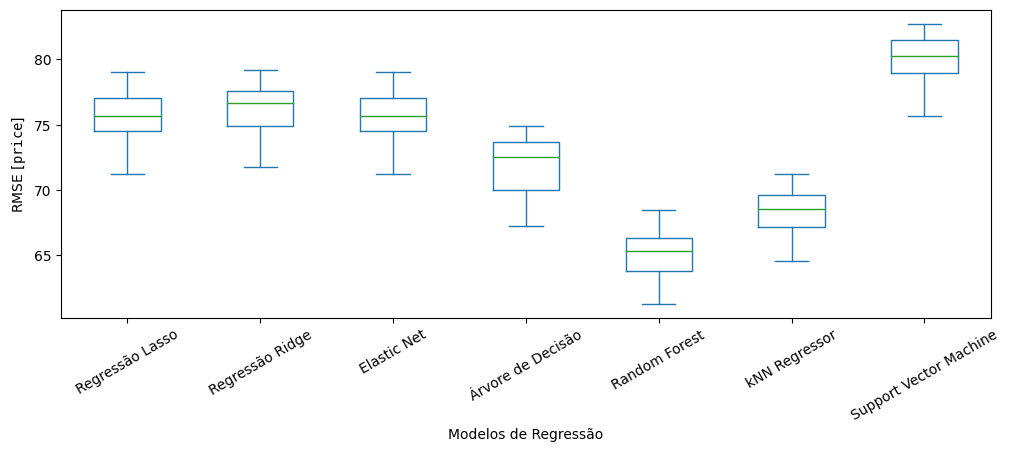

In [69]:
pd.DataFrame(models_scores).plot.box(
    xlabel='Modelos de Regressão',
    ylabel=r'RMSE $[\mathtt{price}]$',
    rot=30,
    figsize=(12, 4),
);

Acima, pode-se ver que as regressões regularizadas possuem desempenho parecido em termos de RMSE (a Regressão Linear não foi plotada pois seu erro extrapola e está muito acima dos demais modelos). O modelo que apresentou maior erro foi o *support vector machine*, enquanto que o melhor desempenho ficou para a floresta aleatória. O kNN foi o segundo modelo a apresentar os menores erros, seguido da árvore de decisão.

In [70]:
models_preds = {
    "Regressão Lasso": y_pred_lasso,
    "Regressão Ridge": y_pred_ridge,
    "Elastic Net": y_pred_enet,
    "Árvore de Decisão": y_pred_tree,
    "Random Forest": y_pred_forest,
    "kNN Regressor": y_pred_knn,
    "Support Vector Machine": y_pred_svm
}

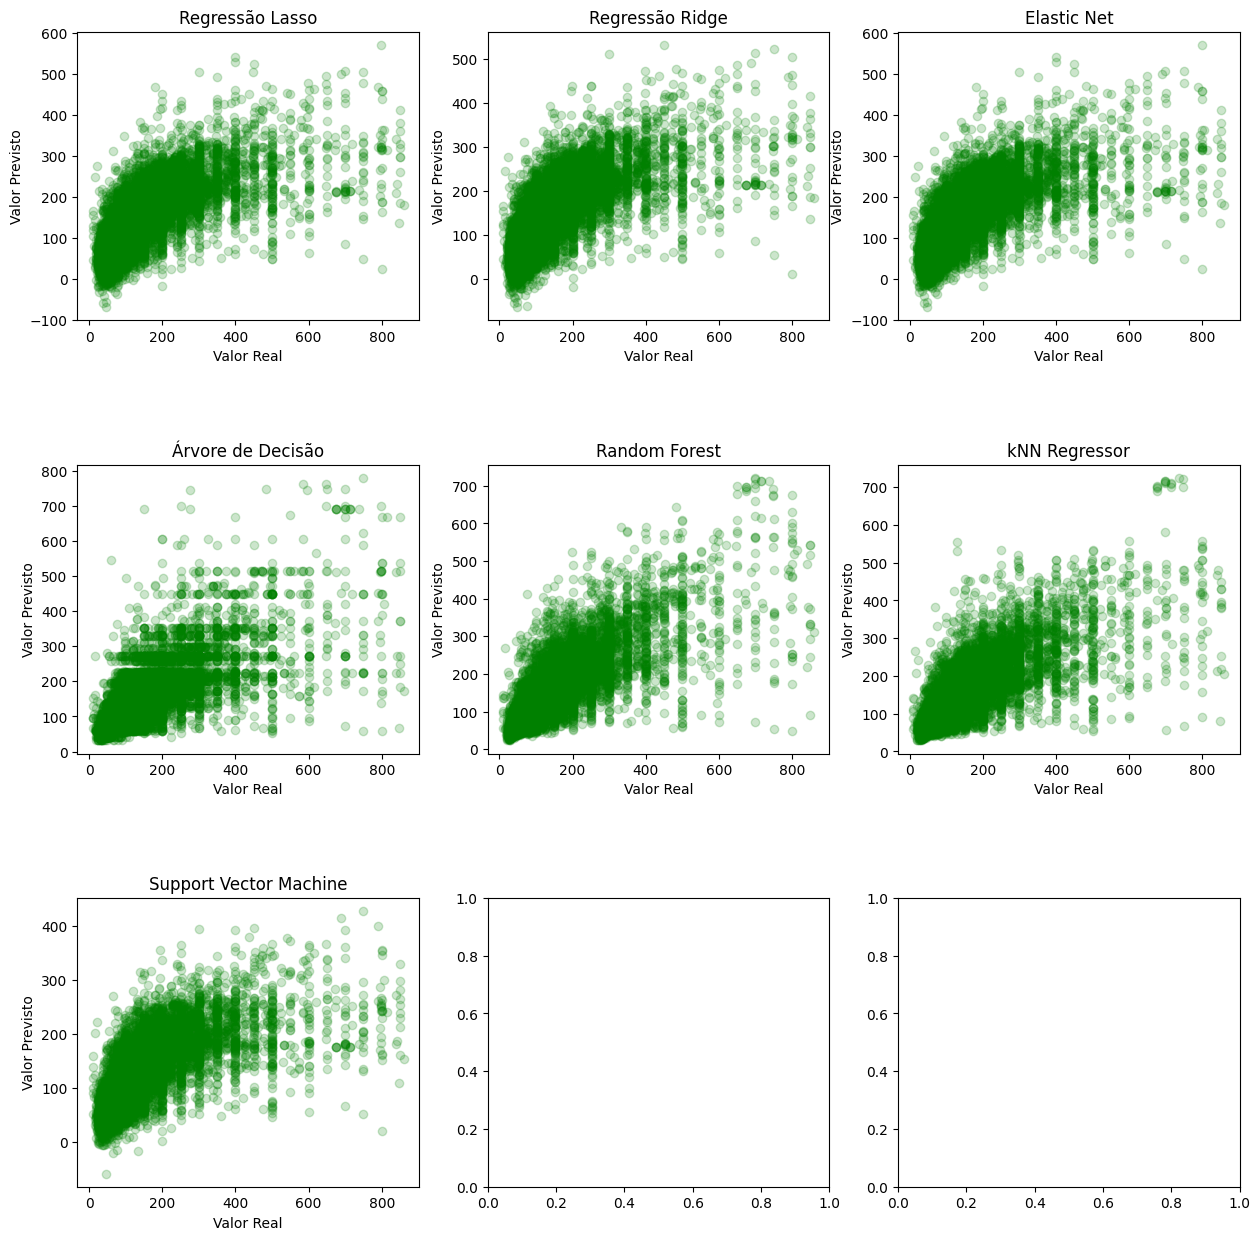

In [71]:
i = 1
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

for title, y_pred in models_preds.items():
    plt.subplot(3,3,i)
    plt.plot(y_test, y_pred, 'o', c="green", alpha=0.2)
    plt.xlabel("Valor Real")
    plt.ylabel("Valor Previsto")
    plt.title(title)
    i += 1
    
plt.show()

Podemos ver que, para os modelos de Árvore de Decisão, *Random Forest* e kNN, a nuvem "valor real" *vs* "valor previsto" parece mais alinhada à linha diagonal, o que indica mais previsões mais próximas do valor real e, portanto, menor erro nas previsões. Nos demais modelos, houve um maior número de previsões cujos valores foram maiores que o valor real.

---
# Conclusão

Pode-se, concluir, portanto, que o modelo de melhor performance foi a `Random Forest`, seguida da `KNN Regressor`. Porém, desempenho não é o único fator relevante a se levar em conta. Talvez seja para o propósito deste notebook, mas, para aplicações no mundo real, é necessário balancear o desempenho com outros fatores, como o tempo de processamento (14.9 s -- random forest <i> vs. </i> 516 ms -- KNN regressor), os custos envolvidos para manter um modelo robusto em produção, a necessidade de precisão etc.


Talvez ainda seja possível melhorar ainda mais o desempenho dos modelos. Para isso, poderíamos:
- Aumentar a quantidade de dados (abrangendo outros anos, por exemplo ou aprimorando os dados faltantes com dados reais)
- Realizar um tratamento mais displicentes dos dados
- Testar mais hiperparâmetros


---

# Referências

- GÉRON, A. Mãos à Obra: **Aprendizado de Máquina com Scikit-Learn & TensorFlow: Conceitos, Ferramentas e Técnicas Para a Construção de Sistemas Inteligentes**. Rio de Janeiro: Alta Books, 2019.
- Página oficial do [Scikit-Learn](https://scikit-learn.org/stable/).
- Conteúdo de *machine learning* da página [GeeksForGeeks](https://www.geeksforgeeks.org/machine-learning/).
- Notebooks de aula de *Machine Learning*.

#### Projetos do Kaggle que serviram de inspiração

- *Spatial Analysis of Airbnb listings in NYC*. Disponível em: https://www.kaggle.com/code/geowiz34/maps-of-nyc-airbnbs-with-python.
- *Airbnb Analysis, Visualization and Prediction*. Disponível em: https://www.kaggle.com/code/chirag9073/airbnb-analysis-visualization-and-prediction.